In [1]:
import os.path as osp
import sys
from pathlib import Path
import matplotlib.pyplot as plt

root_path = Path(osp.abspath("")).parents[1]
sys.path.append(str(root_path))

%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
from algorithm import SmoothedPath
from core.curve import Line, Bezier
from core.toolpath import LinearPath
import utils.visualization as vis
from core.look_ahead import BidirectionalScanner

In [3]:
data_name = "dolphin"
file_path = f"./data/{data_name}.txt"
data_pts = np.loadtxt(file_path, delimiter="\t")
Ts = 0.0005

V_MAX = 100
A_MAX = 3000
J_MAX = 60000
chord_error = 0.05
c1 = 0.5

print(f"Loaded data from {file_path}")
print(f"Data points shape: {data_pts.shape}")

Loaded data from ./data/dolphin.txt
Data points shape: (200, 2)


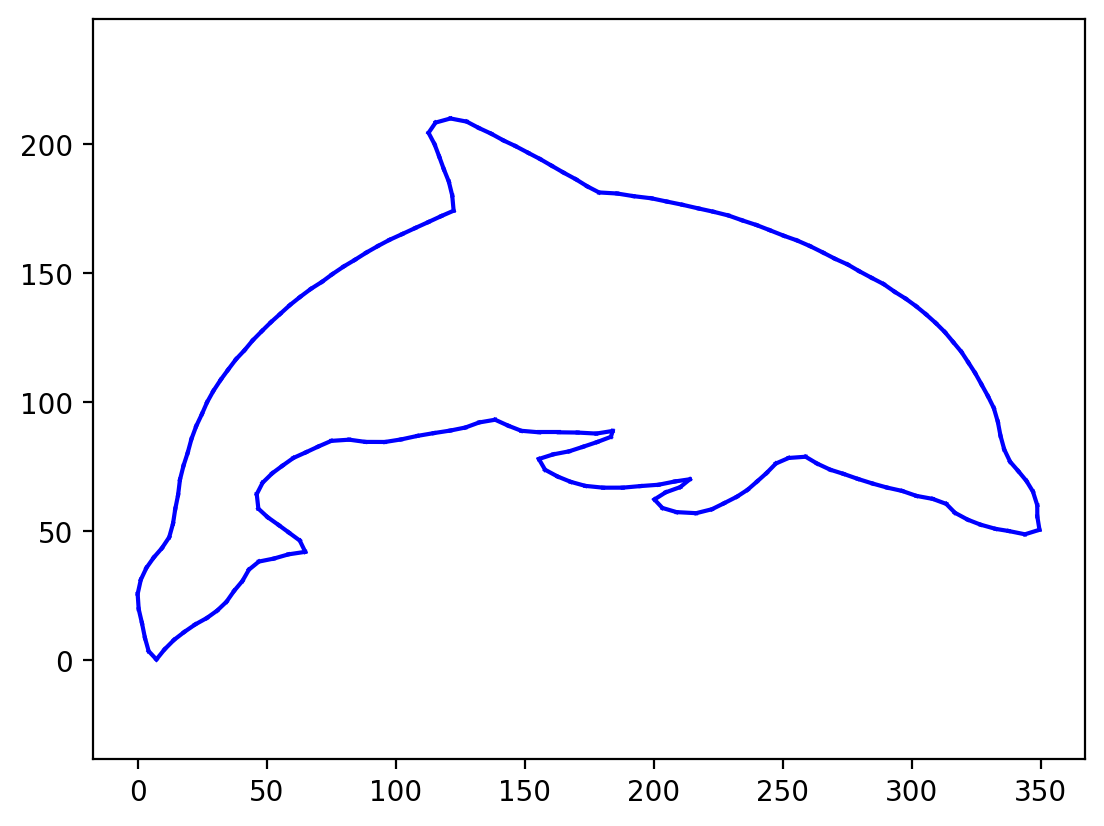

Total arc length: 1098.0720517475365


In [4]:
linear_path = LinearPath(data_pts, chord_error)
vis.plot_toolpath(linear_path)
linear_path_lengths = [block.length for block in linear_path.blocks]
print(f"Total arc length: {np.sum(linear_path_lengths)}")

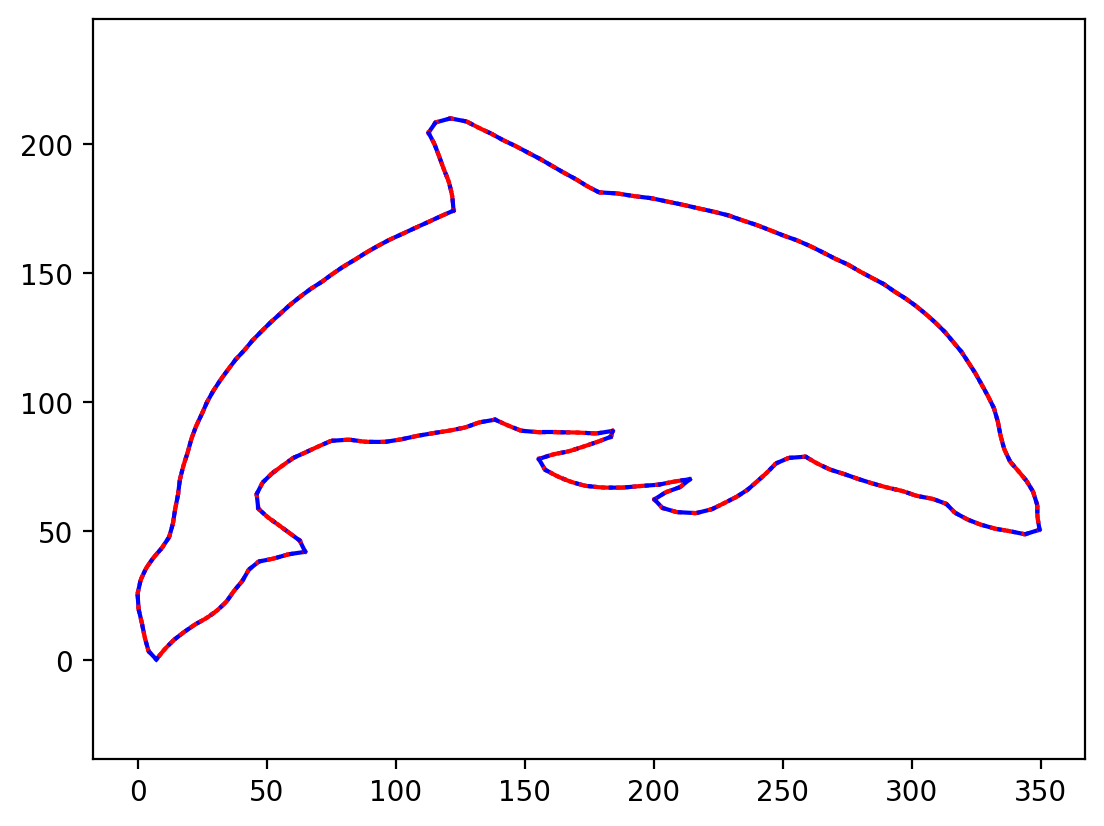

Total arc length: 1096.9265151417633
Max curvature: 177.12231383602168


In [5]:
smooth_path = SmoothedPath(data_pts, chord_error, c1)
vis.plot_toolpath(smooth_path)
smooth_path_lengths = [block.length for block in smooth_path.blocks]
print(f"Total arc length: {np.sum(smooth_path_lengths)}")
print(f"Max curvature: {np.max(smooth_path.curvatures)}")

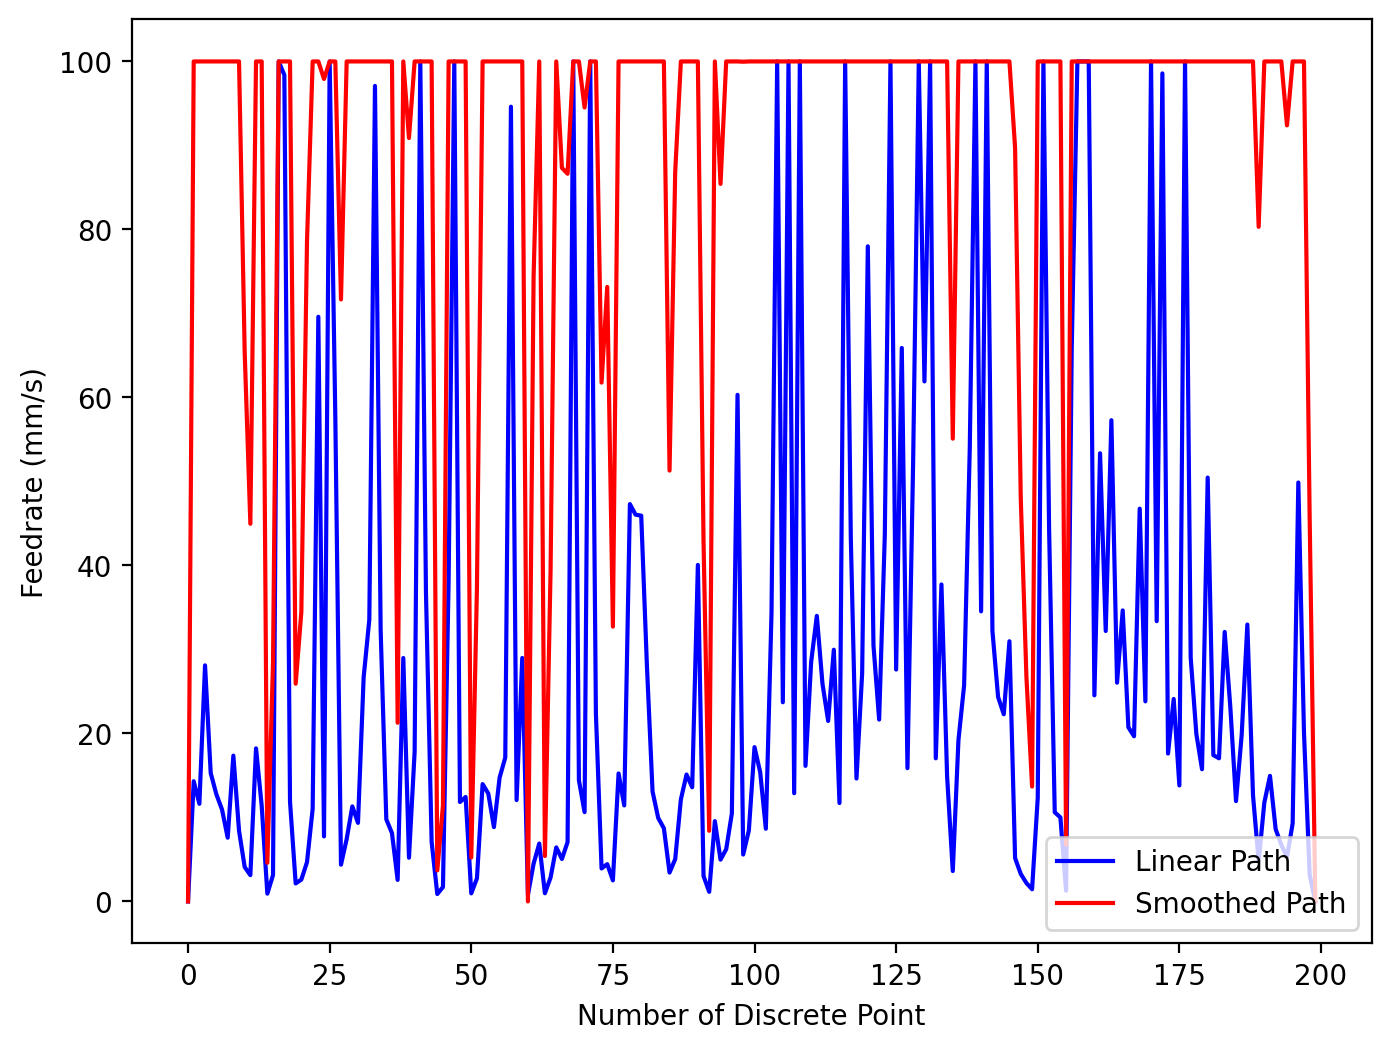

In [6]:
linear_scanner = BidirectionalScanner(linear_path, Ts, V_MAX, A_MAX, J_MAX)

scanner_smooth = BidirectionalScanner(smooth_path, Ts, V_MAX, A_MAX, J_MAX)

v_lim_linear = linear_scanner.v_limit
v_lim_smooth = scanner_smooth.v_limit


plt.figure(figsize=(8, 6))
plt.plot(v_lim_linear, "b-", label="Linear Path")
plt.plot(v_lim_smooth, "r-", label="Smoothed Path")
plt.xlabel("Number of Discrete Point")
plt.ylabel("Feedrate (mm/s)")
plt.legend(loc="lower right")
plt.show()

In [7]:
from core.feedrate_scheduler import FeedrateScheduler

smooth_scheduler = FeedrateScheduler(smooth_path_lengths, v_lim_smooth, V_MAX, A_MAX, J_MAX, Ts)
smooth_profiles = smooth_scheduler.profiles
print(f"Total time: {smooth_scheduler.total_time}")
smooth_profile_data = smooth_scheduler.get_profile_data()

Total time: 12.428292519121293


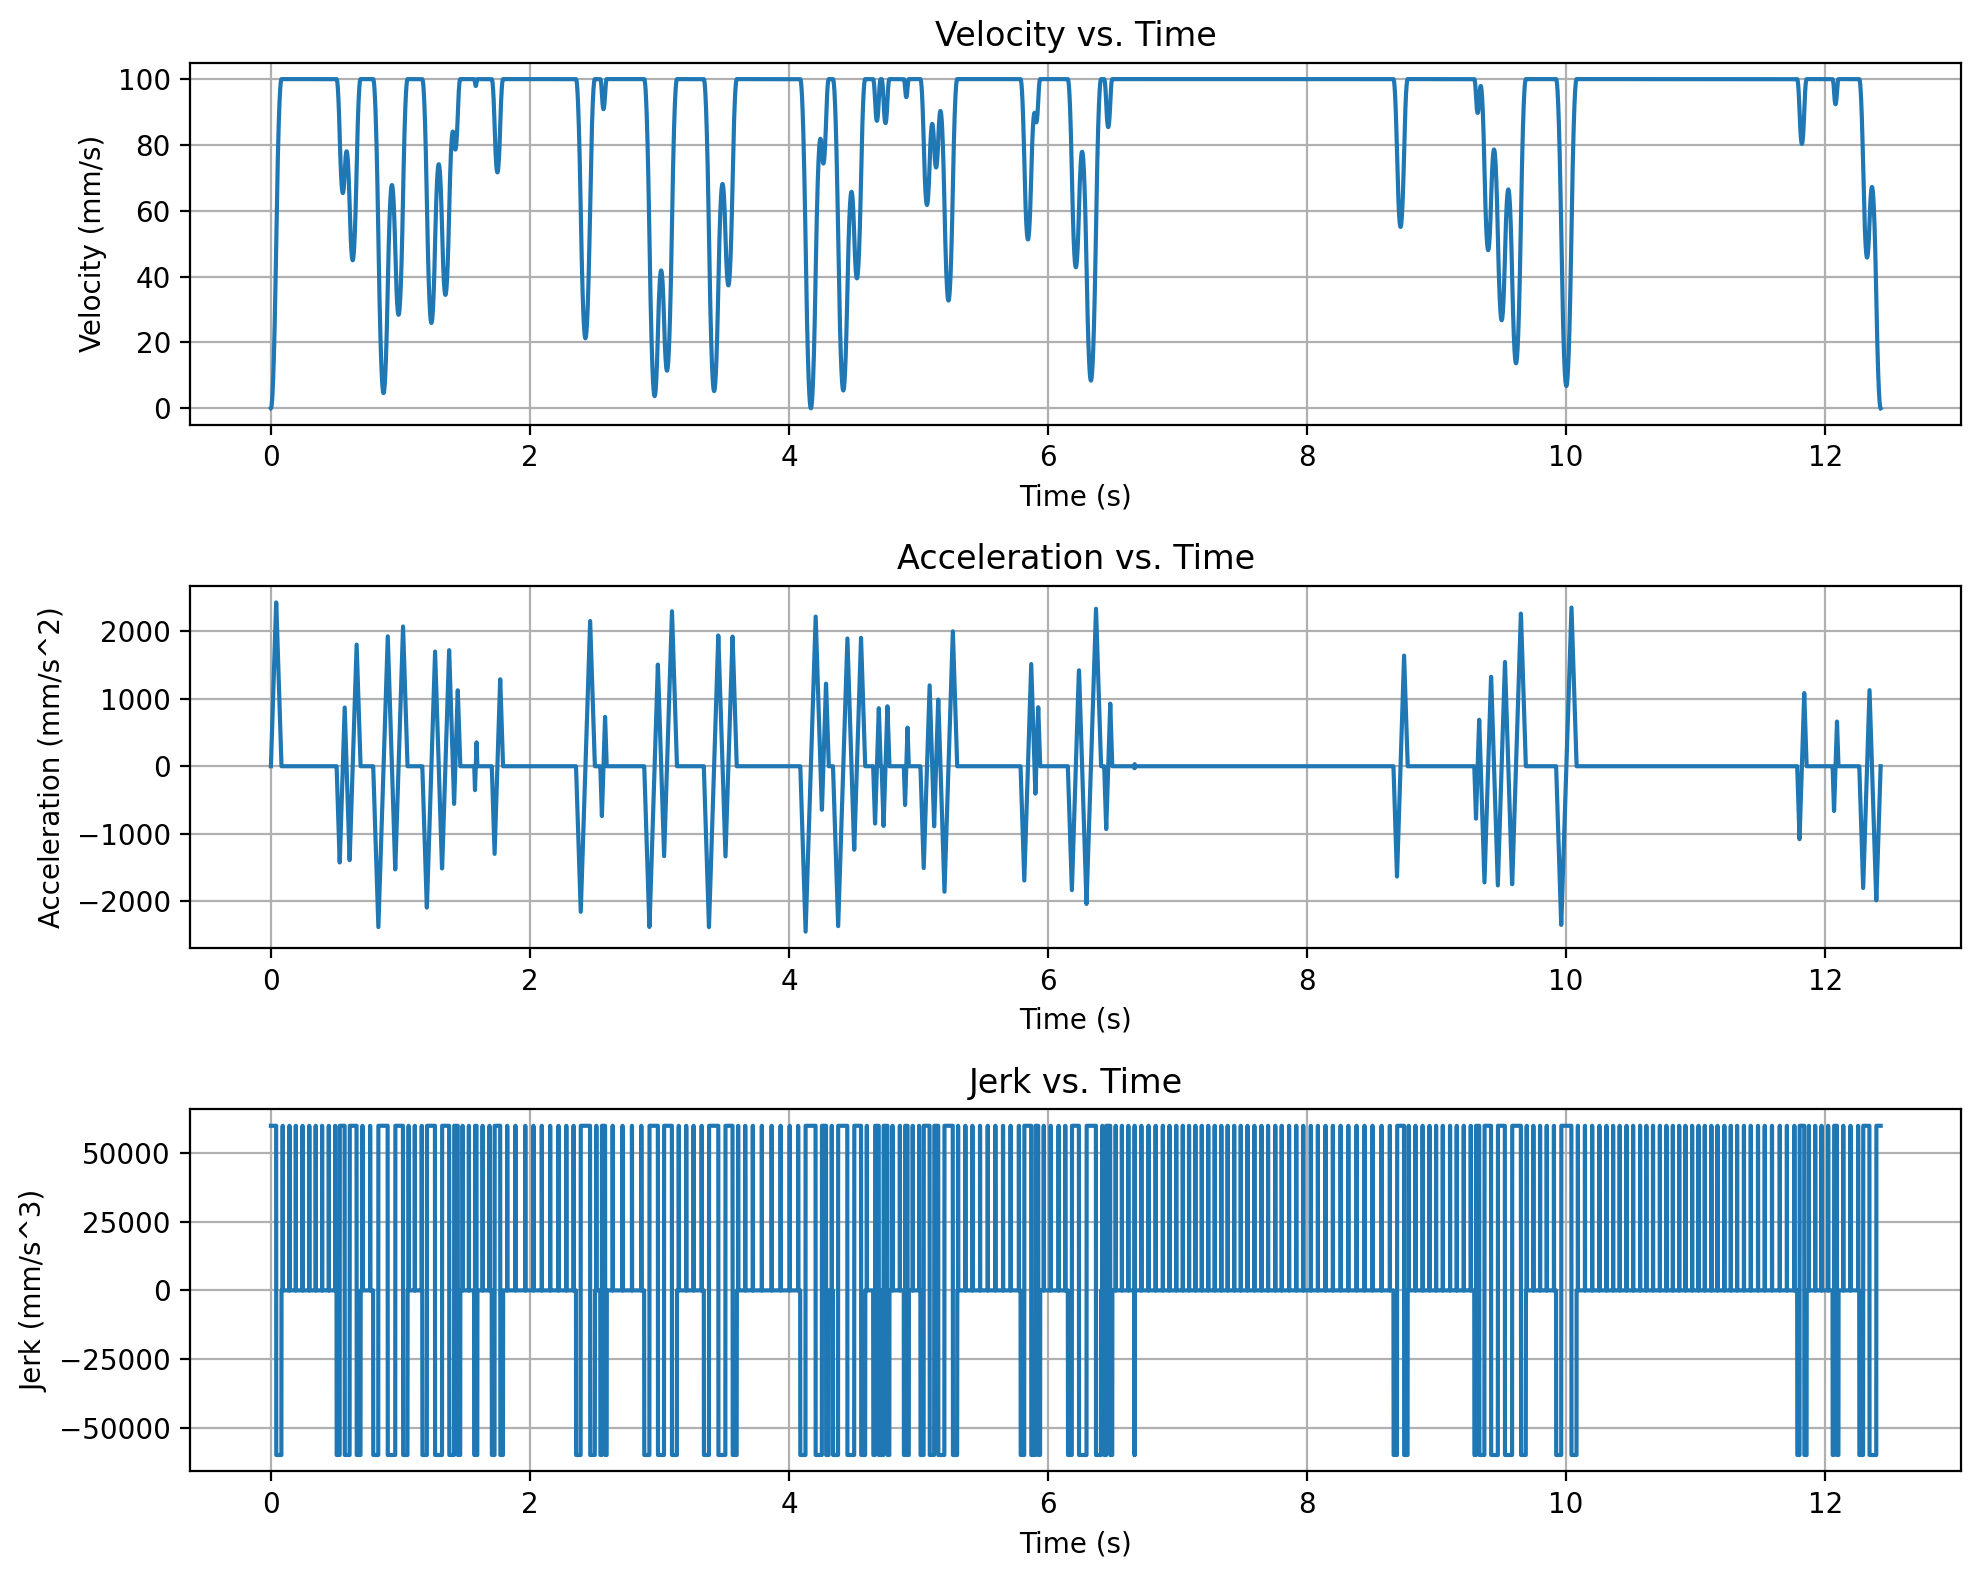

In [8]:
vis.plot_profiles(smooth_profile_data)

In [9]:
linear_scheduler = FeedrateScheduler(linear_path_lengths, v_lim_linear, V_MAX, A_MAX, J_MAX, Ts)
linear_profiles = linear_scheduler.profiles
print(f"Total time: {linear_scheduler.total_time}")
linear_profile_data = linear_scheduler.get_profile_data()

Total time: 22.2002911823999


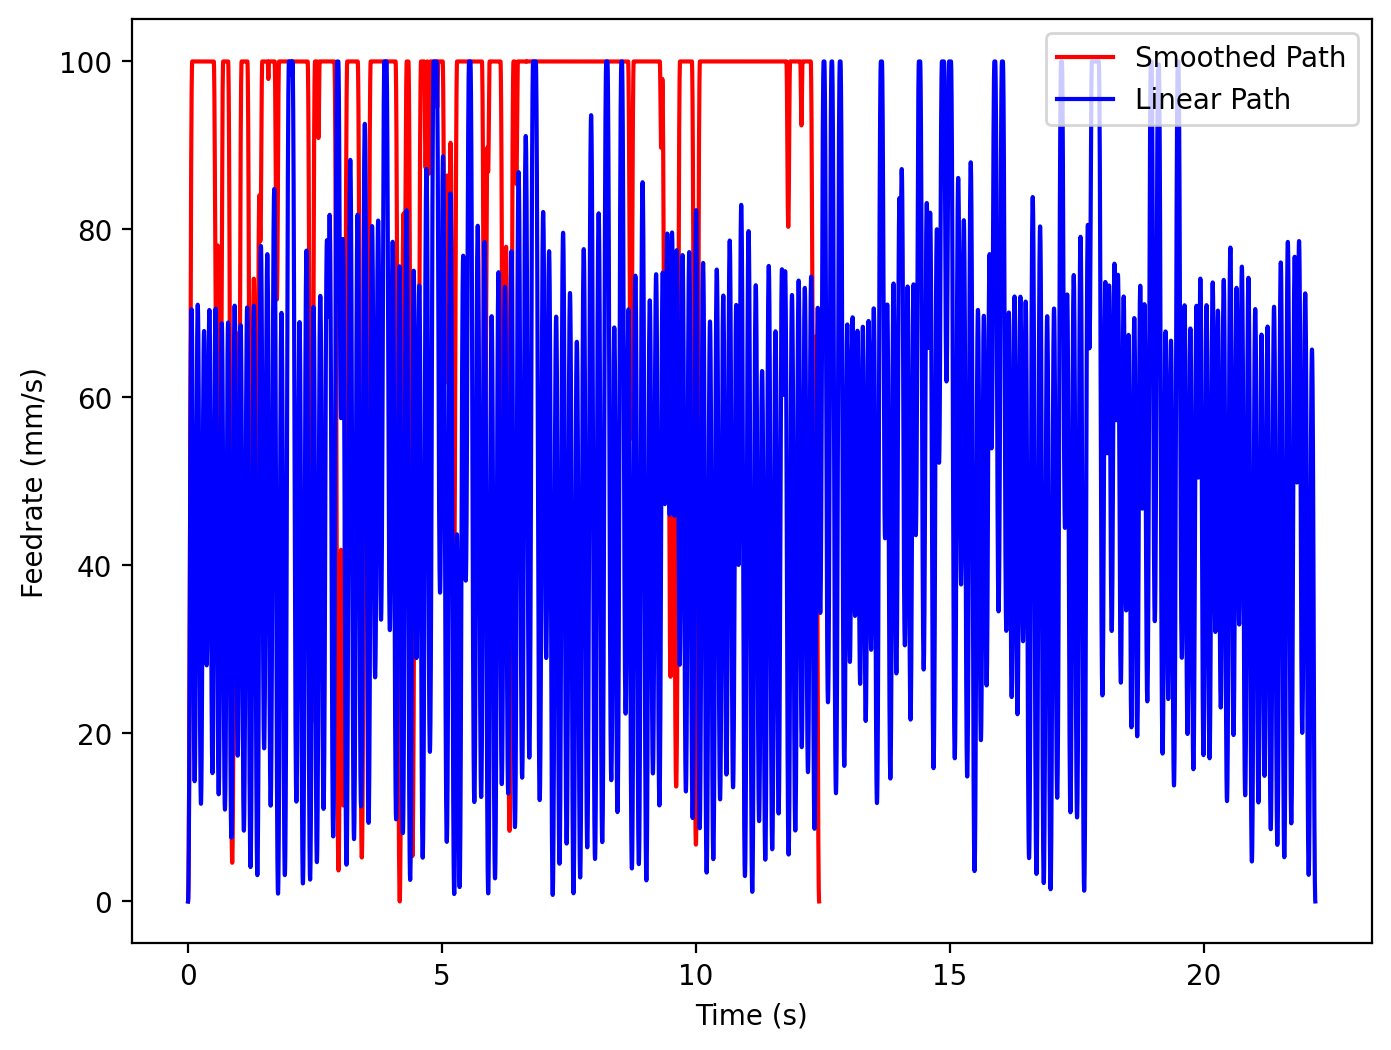

In [10]:
# vis.plot_profiles(linear_profile_data)
T_smooth, V_smooth = smooth_profile_data["T"], smooth_profile_data["V"]
T_linear, V_linear = linear_profile_data["T"], linear_profile_data["V"]
plt.figure(figsize=(8, 6))
plt.plot(T_smooth, V_smooth, "r-", label="Smoothed Path")
plt.plot(T_linear, V_linear, "b-", label="Linear Path")
plt.xlabel("Time (s)")
plt.ylabel("Feedrate (mm/s)")
plt.legend(loc="upper right")
plt.show()